XGBOOST 与GDBT的区别

XGBoost⽣成CART树考虑了树的复杂度，GDBT未考虑，GDBT在树的剪枝步骤中考虑了树的复杂度<br/>
XGBoost是拟合上⼀轮损失函数的⼆阶导展开，GDBT是拟合上⼀轮损失函数的⼀阶导展开，因此，XGBoost
的准确性更⾼，且满⾜相同的训练效果，需要的迭代次数更少<br/>
XGBoost与GDBT都是逐次迭代来提⾼模型性能，但是XGBoost在选取最佳切分点时可以开启多线程进⾏，⼤
⼤提⾼了运⾏速度


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train_data = pd.read_csv('data/otto/train.csv')
train_data.head()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,target
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,Class_1
1,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
2,3,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,Class_1
3,4,1,0,0,1,6,1,5,0,0,...,0,1,2,0,0,0,0,0,0,Class_1
4,5,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,Class_1


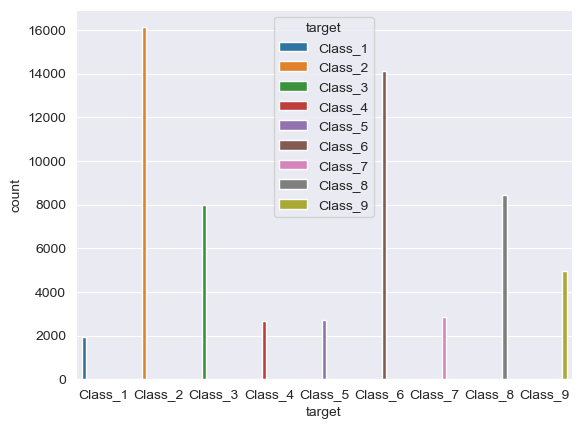

In [5]:
sns.countplot(data=train_data, x='target', hue='target')
plt.show()

In [6]:
y = train_data['target']
x = train_data.drop(['target', 'id'], axis=1)
print(x.shape)
print(y.shape)

(61878, 93)
(61878,)


In [7]:
from imblearn.under_sampling import RandomUnderSampler

random_under_sampler = RandomUnderSampler(random_state=0)
x_sampler, y_sampler = random_under_sampler.fit_resample(x, y)
y_sampler.head()

0    Class_1
1    Class_1
2    Class_1
3    Class_1
4    Class_1
Name: target, dtype: object

<Axes: xlabel='target', ylabel='count'>

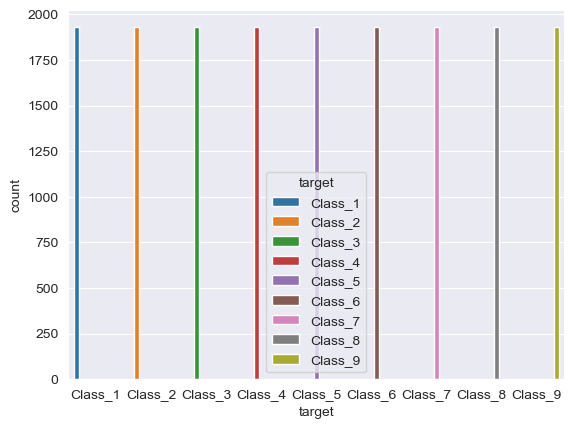

In [8]:
sns.countplot(data=pd.DataFrame(y_sampler), x='target', hue='target')

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_sampler = le.fit_transform(y_sampler)
y_sampler

array([0, 0, 0, ..., 8, 8, 8])

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_sampler, y_sampler, random_state=0, test_size=0.2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(13888, 93) (13888,) (3473, 93) (3473,)


In [11]:
#通过straifedShuffleSplit进行数据分割，测试集数量更平整
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in sss.split(x_sampler.values, y_sampler):
    print(len(train_index))
    print(len(test_index))

    x_train = x_sampler.values[train_index]
    x_val = x_sampler.values[test_index]

    y_train = y_sampler[train_index]
    y_val = y_sampler[test_index]

13888
3473


In [12]:
#数据标准化
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaler = scaler.fit_transform(x_train)
x_test_scaler = scaler.transform(x_val)

In [17]:
#pca降维
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)
x_train_pca = pca.fit_transform(x_train_scaler)
x_val_pca = pca.transform(x_test_scaler)

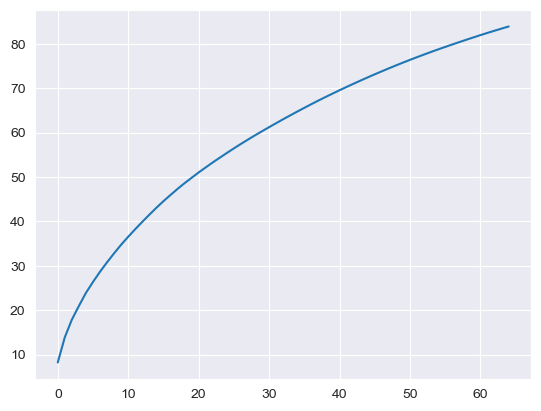

In [14]:
plt.plot(np.cumsum(pca.explained_variance_))

In [18]:
from xgboost import XGBClassifier
from sklearn.metrics import log_loss

scores_ne = []
n_estimators = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
for nes in n_estimators:
    xgb = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=nes, objective='multi:softprob', random_state=0,
                        n_jobs=-1, nthread=4, min_child_weight=1, subsample=1,
                        colsample_bytree=1,
                        seed=42)
    xgb.fit(x_train_pca,y_train)
    y_pre=xgb.predict_proba(x_val_pca)
    score=log_loss(y_val,y_pre)
    scores_ne.append(score)

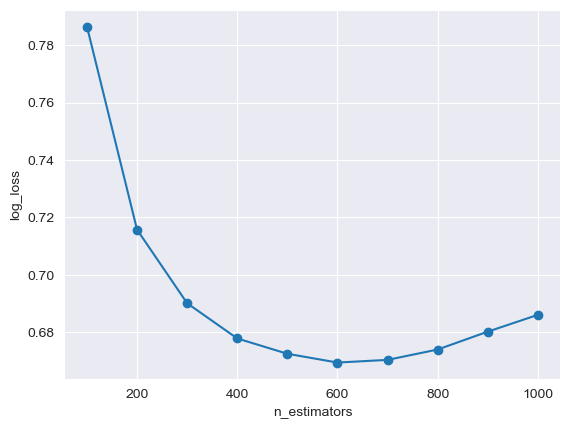

In [19]:
plt.plot(n_estimators,scores_ne,"o-")
plt.xlabel("n_estimators")
plt.ylabel("log_loss")
plt.show()